### An attempt at reconciling the different notions of contamination in rct. 

Create a figure to demonstrate sources of variability when there is cluster. 

Although, the sources of variability may not affect the estimated treatment effect. That is, the actual value is not affected. Instead, the variance component is affect and that in turn affects the type I and II errors.

In [1]:
tab_fig_path='/burg/biostats/users/ek3235/RCTcontamination/contamiation_in_rct/tables_and_figures/'

In [2]:
source('utils.r') # heritable functions. Add plot functions later


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [62]:
g1_var=3

g2_var=7

g1g2_cov=1

matrix(c(g1_var, g1g2_cov, g1g2_cov, g2_var), nrow=2)

matrix(c(sigma_b, 0.01,  0.01, sigma_b/0.9), nrow=2) 


3,1
1,7


0.001,0.010000000
0.010,0.001111111


In [64]:
## Create a function to estimate beta-hat and take the mean of that.
beta.hats.func=function(beta=0.2, 
                        N=1000, k=10,
                        sigma_e=1,icc=0.5,
                        nsim=1000,
                        cluster.assign.type=c('random', 'control', 'cluster', 'complete', 'control.interact')){

    cluster.type=match.arg(cluster.assign.type) # check if cluster type matches what is expected. 
    
    sigma_b=icc*sigma_e/(1-icc)
    
    beta.est=NULL
    sig.ind=NULL # check if significant or not. 
    
    if (cluster.type=='random'){
        for ( i in 1:nsim){
            # Randomize patients to treatment
            trt=rbinom(n=N,size=1, prob=0.5)

            ## If assigning doctors to patients in a random fashion without conditioning on treatment assigned to
            cluster.assigment=sample(1:k, size=N, replace=TRUE)

            # # x-beta 
            xb=beta*trt # make sure to use the treatment variable that acts behind the scene!

            # # simulate cluster random intercept (for now)  
            clust.eff=rnorm(n=k, mean=0, sd=sigma_b) # number of clusters is k

            clust.eff.vec=clust.eff[cluster.assigment] # assign each cluster to its random intercept 

            # # generate outcome variable yijk using equation in model 1. 
            y=rnorm(N, mean=xb,  sd=sigma_e)+clust.eff.vec

            clust.df=data.frame(y=y, trt=trt,cluster.assigned=cluster.assigment, 
                    cluster_random_interc=clust.eff.vec) # add icc, number of clusters at a later date. 
        
            # check if significant. 
            model1=lm(y~trt, data=clust.df)
            sig.ind[i]= summary(model1)$coeff['trt','Pr(>|t|)']<0.05
            # sig.ind[i]=t.test(y~trt, data=clust.df, var.equal=TRUE)$p.value<0.05 # ignoring cluster assignment
        
            beta.est[i]=mean(y[trt==1])-mean(y[trt==0])}
        
        
    }else if (cluster.type=='control'){
        # Randomize patients to treatment 
        for  (i in 1:nsim){
            trt=rbinom(n=N,size=1, prob=0.5)

            trt=sort(trt) # sort 
            ni=N/2

            ## Assign to clusters in a controlled fashion. 
            cluster.assigment=c( rep(1:k, each=ni/k ), rep(1:k, each=ni/k ))

            # # x-beta 
            xb=beta*trt # make sure to use the treatment variable that acts behind the scene!

            # # simulate cluster random intercept (for now)  
            clust.eff=rnorm(n=k, mean=0, sd=sigma_b) # number of clusters is k

            clust.eff.vec=clust.eff[cluster.assigment] # assign each cluster to its random intercept 

            # # generate outcome variable yijk using equation in model 1. 
            y=rnorm(N, mean=xb,  sd=sigma_e)+clust.eff.vec

            clust.df=data.frame(y=y, trt=trt,cluster.assigned=cluster.assigment, 
                    cluster_random_interc=clust.eff.vec) # add icc, number of clusters at a later date. 

            # check if significant. 
            model1=lm(y~trt, data=clust.df)
            sig.ind[i]= summary(model1)$coeff['trt','Pr(>|t|)']<0.05
    #         sig.ind[i]=t.test(y~trt, data=clust.df, var.equal=TRUE)$p.value<0.05 # ignoring cluster assignment

            beta.est[i]=mean(y[trt==1])-mean(y[trt==0])}
    
    }else if (cluster.type=='cluster'){
        # Generate cluster id 
        for ( i in 1:nsim){
            cluster.assigment=sample(x=1:k,size=N, replace=TRUE)

            # Randomize treatment to the k clusters. 
            trt.cluster=rbinom(n=k,size=1, prob=0.5)

            # arrest cases where randomization to treatment results to all
                #clusters being randomized to the same treatment
            while(length(table(trt.cluster))!=2){
                trt.cluster=rbinom(n=k,size=1, prob=0.5)}

            trt=trt.cluster[cluster.assigment] # assign each cluster to its appropriate treatment. 

            xb=beta*trt

            # simulate cluster random intercept (for now)  
            clust.eff=rnorm(n=k, mean=0, sd=sigma_b) # number of clusters is k

            clust.eff.vec=clust.eff[cluster.assigment] # assign each cluster to its random intercept 

            # generate outcome variable yijk using equation in model 1. 
            y=rnorm(N, mean=xb,  sd=sigma_e)+clust.eff.vec

            clust.df=data.frame(y=y, trt=trt,cluster.assigned=cluster.assigment, 
            cluster_random_interc=clust.eff.vec) # add icc, number of clusters at a later date. 
        
            # check if significant. 
            model1=lm(y~trt, data=clust.df)
            sig.ind[i]= summary(model1)$coeff['trt','Pr(>|t|)']<0.05

            #sig.ind[i]=t.test(y~trt, data=clust.df, var.equal=TRUE)$p.value<0.05 # ignoring cluster assignment

            beta.est[i]=mean(y[trt==1])-mean(y[trt==0])}
    
    }else if(cluster.type=='complete'){
        
        ## Assign to clusters using complete block design. Randomize within cluster, that is.  
        for ( i in 1:nsim){
            
            cluster.assigment=sample(1:k, size=N, replace=TRUE)

            # Randomize patients to treatment within each cluster 
            trt=NULL
            
            count_freq.df=as.data.frame(table(cluster.assigment)) # extract count and freq of selected clusters
            cluster.count=count_freq.df[,2] # count 
            cluster.id=count_freq.df[,1] # cluster  id. some 
            #clusters may not be selected by random chance
            for(j in 1:length(cluster.id) ){
                trt[cluster.assigment==cluster.id[j]]=rbinom(n=cluster.count[j], size=1, prob=0.5)}

            # # x-beta 
            xb=beta*trt # make sure to use the treatment variable that acts behind the scene!

            # # simulate cluster random intercept (for now)  
            clust.eff=rnorm(n=k, mean=0, sd=sigma_b) # number of clusters is k

            clust.eff.vec=clust.eff[cluster.assigment] # assign each cluster to its random intercept 

            # # generate outcome variable yijk using equation in model 1. 
            y=rnorm(N, mean=xb,  sd=sigma_e)+clust.eff.vec

            clust.df=data.frame(y=y, trt=trt,cluster.assigned=cluster.assigment, 
                cluster_random_interc=clust.eff.vec) # add icc, number of clusters at a later date. 

            # check if significant. 
            model1=lm(y~trt, data=clust.df)
            sig.ind[i]= summary(model1)$coeff['trt','Pr(>|t|)']<0.05
    #         sig.ind[i]=t.test(y~trt, data=clust.df, var.equal=TRUE)$p.value<0.05 # ignoring cluster assignment

            beta.est[i]=mean(y[trt==1])-mean(y[trt==0])}
    }else{
        # Randomize patients to treatment then to clusters but include random slope interaction with treatment
        for  (i in 1:nsim){
            trt=rbinom(n=N,size=1, prob=0.5)

            trt=sort(trt) # sort 
            ni=N/2

            ## Assign to clusters in a controlled fashion. 
            cluster.assigment=c( rep(1:k, each=ni/k ), rep(1:k, each=ni/k ))

            # # x-beta 
            xb=beta*trt # make sure to use the treatment variable that acts behind the scene!

          # # simulate cluster random intercept + random slope. 
            varcov.mat=matrix(c(sigma_b, 0.01,  0.01, sigma_b/0.9), nrow=2) # 
            clust.eff=mvrnorm(n = k, rep(0, 2), varcov.mat) #rnorm(n=k, mean=0, sigma_b) # number of clusters is k

            clust.eff.mat=clust.eff[cluster.assigment, ] # assign each cluster to its random intercept 

            # # # generate outcome variable yijk using equation in model 1. 
            y=rnorm(N, mean=xb,  sigma_e)+clust.eff.mat[,1]+clust.eff.mat[,2]*trt

            # # combine into a dataframe 
            cluster_random_eff=clust.eff.mat
            colnames(cluster_random_eff)=c('randm interc', 'randm slope')
            clust.df=data.frame(y=y, trt=trt,cluster.assigned=cluster.assigment, 
                                cluster_random_eff) # add icc, number of clusters at a later date. 
    
            # check if significant. 
            model1=lm(y~trt, data=clust.df)
            sig.ind[i]= summary(model1)$coeff['trt','Pr(>|t|)']<0.05
    #         sig.ind[i]=t.test(y~trt, data=clust.df, var.equal=TRUE)$p.value<0.05 # ignoring cluster assignment

            beta.est[i]=mean(y[trt==1])-mean(y[trt==0])}
    }
    
    pwr.est=round( sum(sig.ind)/nsim, 2)
    sim.df=data.frame(beta.est, est.power=rep(pwr.est, nsim))
    return(sim.df)
}


Suppose we have 10 doctors, icc=0 and we have access to 1000 patients. 

In [4]:
# calculate sample size for specitific type I and II errors and effect size. 
n.group1=cont.sample.size(
                m1=1.0,
                m2=1.2,
                sd=1,
                type_I_error=0.05, 
                type_II_error=0.2)

# calculate power from fixed sample size 
# pwr.func(n=n.group1, 
#         m1=1.0,
#         m2=1.2,
#         sd=1,
#         type_I_error=0.05)

k=10
cluster.pwr.func(
    k=k, 
    m=400/k, 
    mu1=1.0,
    mu2=1.2,
    sd=1,
    icc=0.9,
    type_I_error=0.05)

[1] 0.02546145

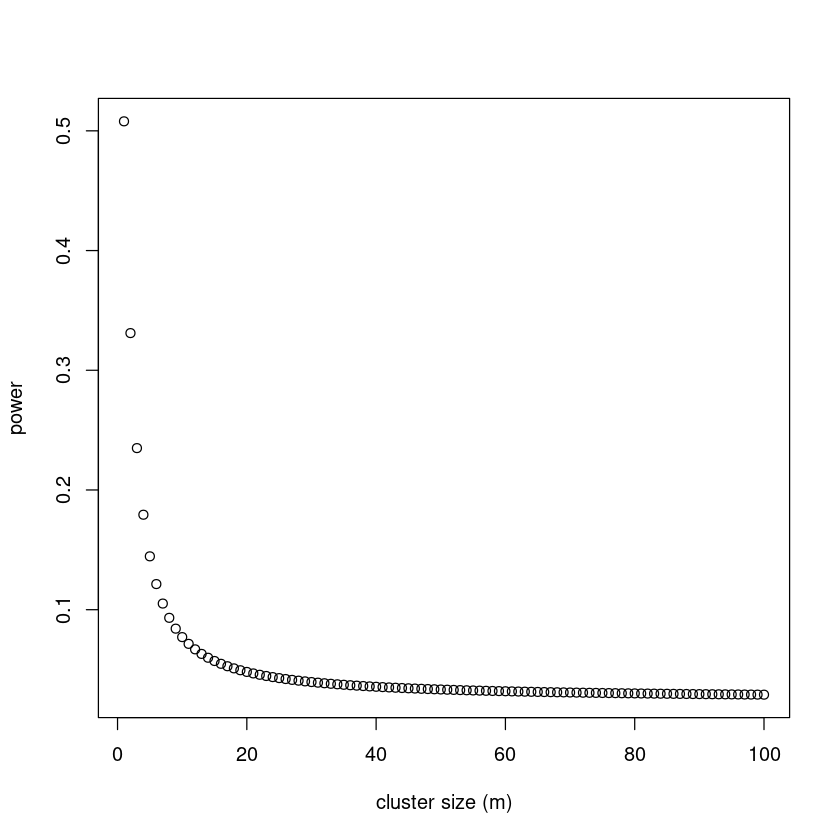

In [5]:
pwr.vs.cluster.size=NULL
seq.icc=seq(0, 1, length.out=100)
for ( i in 1:100){
    pwr.vs.cluster.size[i]=cluster.pwr.func(
    k=400/i, 
    m=i, 
    mu1=1.0,
    mu2=1.2,
    sd=1,
    icc=0.3,
    type_I_error=0.05)
 }

plot(y=pwr.vs.cluster.size, x=1:100, ylab='power', xlab='cluster size (m)')
# power decreases as cluster size increases for a fixed sample size. 

In [6]:
N=400*2
sim.df.random=beta.hats.func(beta=0.2, 
            N=N, k=100,
            sigma_e=1,icc=0.6,
            nsim=1000,
            cluster.assign.type='random')

sim.df.control=beta.hats.func(beta=0.2, 
            N=N, k=100,
            sigma_e=1,icc=0.6,
            nsim=1000,
            cluster.assign.type='control')

sim.df.cluster=beta.hats.func(beta=0.2, 
            N=N, k=100,
            sigma_e=1,icc=0.6,
            nsim=1000,
            cluster.assign.type='cluster')

sim.df.complete=beta.hats.func(beta=0.2, 
            N=N, k=100,
            sigma_e=1,icc=0.6,
            nsim=1000,
            cluster.assign.type='complete')


beta.est.random=sim.df.random[,1]

beta.est.control=sim.df.control[,1]

beta.est.cluster=sim.df.cluster[,1]

beta.est.complete=sim.df.complete[,1]

beta.est.df=data.frame(beta.est.random,beta.est.control, beta.est.cluster, beta.est.complete)

In [7]:
sigma_e=1
icc.from.tau=function(sigma_b){
    return( round( sigma_b/(sigma_b+sigma_e), 2  ) )
}

sigma_b.vec=matrix( c(0, 1, 1.5, 2), nrow=1)

icc.vec=apply(X=sigma_b.vec, MARGIN=2, FUN=icc.from.tau)


pwr.icc=NULL

for(ix in 1:length(icc.vec)){
    pwr.icc[ix]=beta.hats.func(beta=0.2, 
            N=800, k=100,
            sigma_e=1,icc=icc.vec[ix],
            nsim=1000,
            cluster.assign.type='cluster')[1, 2]}
pwr.icc

[1] 0.80 0.52 0.54 0.53

In [8]:
sum(is.null(beta.est.df))

[1] 0

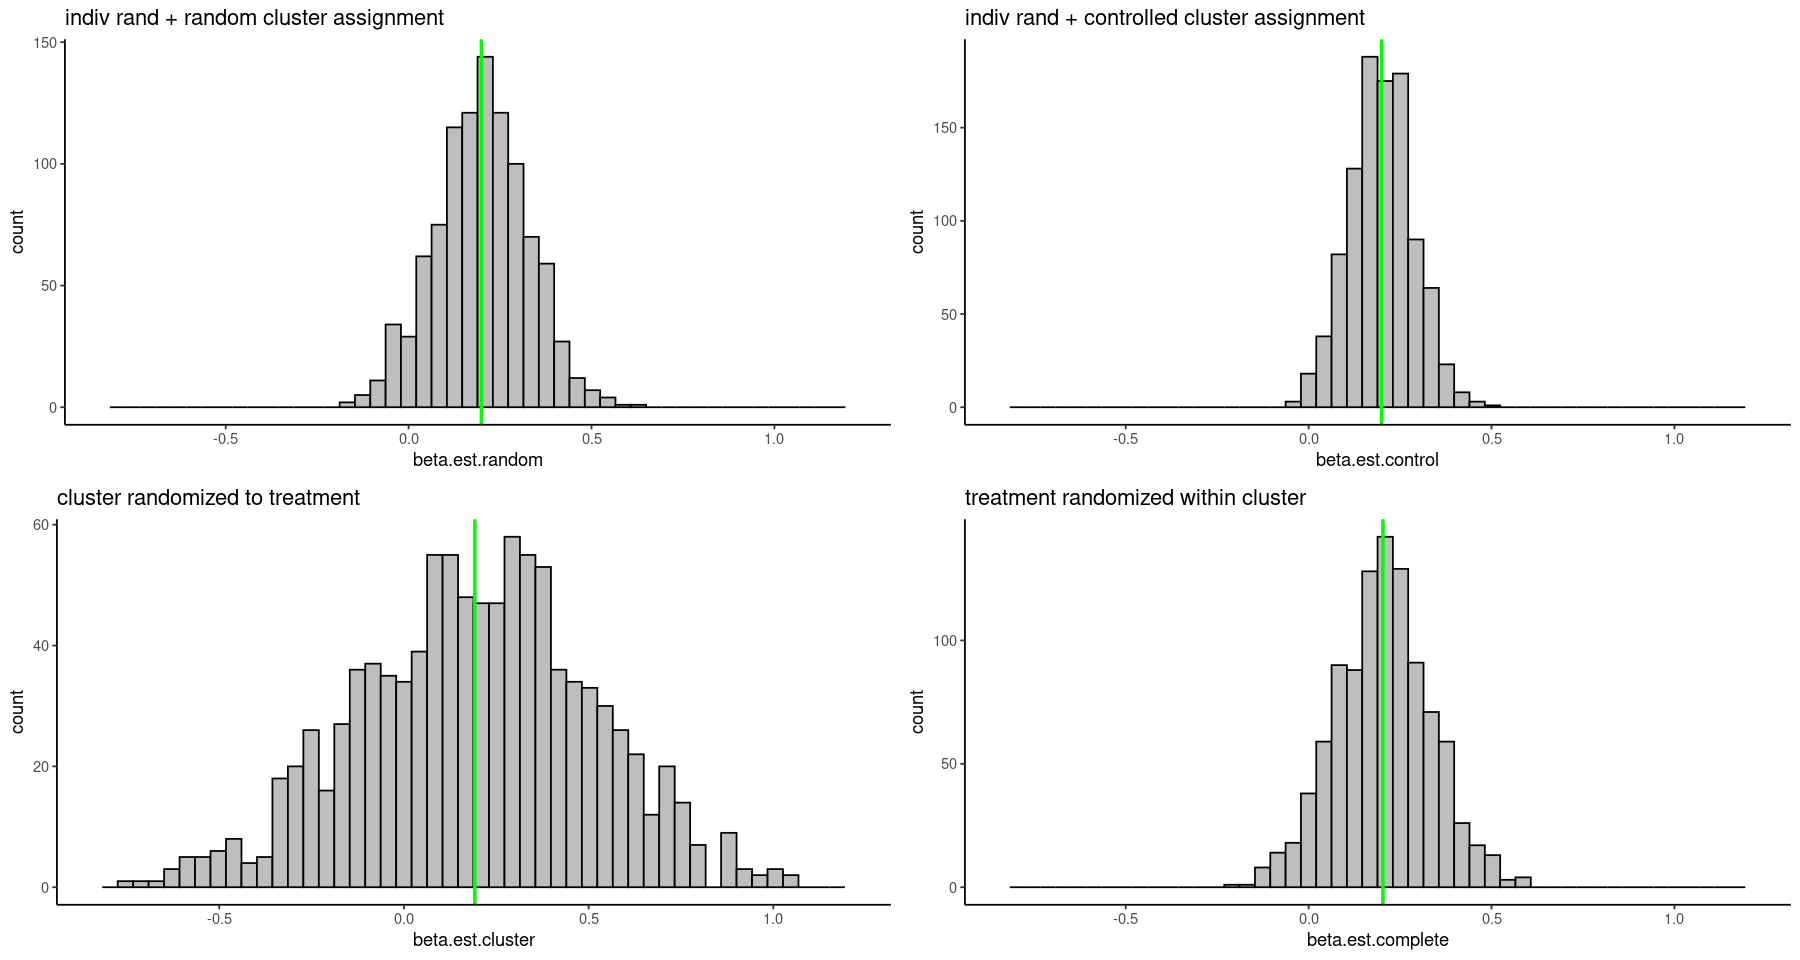

In [9]:
options(repr.plot.width = 15, repr.plot.height =8) 

hist.random=ggplot(beta.est.df, aes(x=beta.est.random)) + 
  geom_histogram(bins=50,color='black',fill='grey' ,na.rm=TRUE)+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+
ggtitle( 'indiv rand + random cluster assignment'  )+
xlim(min(beta.est.df), max(beta.est.df))+
geom_vline(xintercept=mean(beta.est.df$beta.est.random), color = "green", linewidth=1)

hist.control=ggplot(beta.est.df, aes(x=beta.est.control)) + 
  geom_histogram(bins=50,color='black',fill='grey',na.rm=TRUE )+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+
ggtitle( 'indiv rand + controlled cluster assignment' )+
xlim(min(beta.est.df), max(beta.est.df))+
geom_vline(xintercept=mean(beta.est.df$beta.est.control), color = "green", linewidth=1)

hist.cluster=ggplot(beta.est.df, aes(x=beta.est.cluster)) + 
  geom_histogram(bins=50,color='black',fill='grey',na.rm=TRUE )+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+
ggtitle( 'cluster randomized to treatment' )+
xlim(min(beta.est.df), max(beta.est.df))+
geom_vline(xintercept=mean(beta.est.df$beta.est.cluster, na.rm=TRUE), color = "green", linewidth=1)


hist.complete=ggplot(beta.est.df, aes(x=beta.est.complete)) + 
  geom_histogram(bins=50,color='black',fill='grey',na.rm=TRUE )+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+
ggtitle( 'treatment randomized within cluster' )+
xlim(min(beta.est.df), max(beta.est.df))+
geom_vline(xintercept=mean(beta.est.df$beta.est.complete), color = "green", linewidth=1)

grid.arrange(hist.random,hist.control,hist.cluster,hist.complete,ncol=2)

histogram.comparison= arrangeGrob(hist.random,hist.control,hist.cluster,hist.complete,ncol=2) #generates g
# ggsave(file=paste0(tab_fig_path,"beta_hat_estimate_by_clustering_type.svg"), 
#        plot=histogram.comparison, width=15, height=8 )

In [10]:
pwr.est.random=sim.df.random[,2]

pwr.est.control=sim.df.control[,2]

pwr.est.cluster=sim.df.cluster[,2]

pwr.est.complete=sim.df.complete[,2]

pwr.est.df=data.frame(pwr.est.random,pwr.est.control, pwr.est.cluster, pwr.est.complete)
head(pwr.est.df)

,pwr.est.random,pwr.est.control,pwr.est.cluster,pwr.est.complete
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.36,0.28,0.54,0.37
2,0.36,0.28,0.54,0.37
3,0.36,0.28,0.54,0.37
4,0.36,0.28,0.54,0.37
5,0.36,0.28,0.54,0.37
6,0.36,0.28,0.54,0.37


We see that when icc=0, the variability of the estimated beta is considerably similar across the different approaches of cluster assignment. 


Now suppose we have icc=0.5


In [42]:
sim.df.random=beta.hats.func(beta=0.2, 
            N=800, k=100,
            sigma_e=1,icc=0.5,
            nsim=1000,
            cluster.assign.type='random')

sim.df.control=beta.hats.func(beta=0.2, 
            N=800, k=100,
            sigma_e=1,icc=0.5,
            nsim=1000,
            cluster.assign.type='control')

sim.df.cluster=beta.hats.func(beta=0.2, 
            N=800, k=100,
            sigma_e=1,icc=0.5,
            nsim=1000,
            cluster.assign.type='cluster')

sim.df.complete=beta.hats.func(beta=0.2, 
            N=800, k=100,
            sigma_e=1,icc=0.5,
            nsim=1000,
            cluster.assign.type='complete')


beta.est.random=sim.df.random[,1]

beta.est.control=sim.df.control[,1]

beta.est.cluster=sim.df.cluster[,1]

beta.est.complete=sim.df.complete[,1]

beta.est.df=data.frame(beta.est.random,beta.est.control, beta.est.cluster, beta.est.complete)

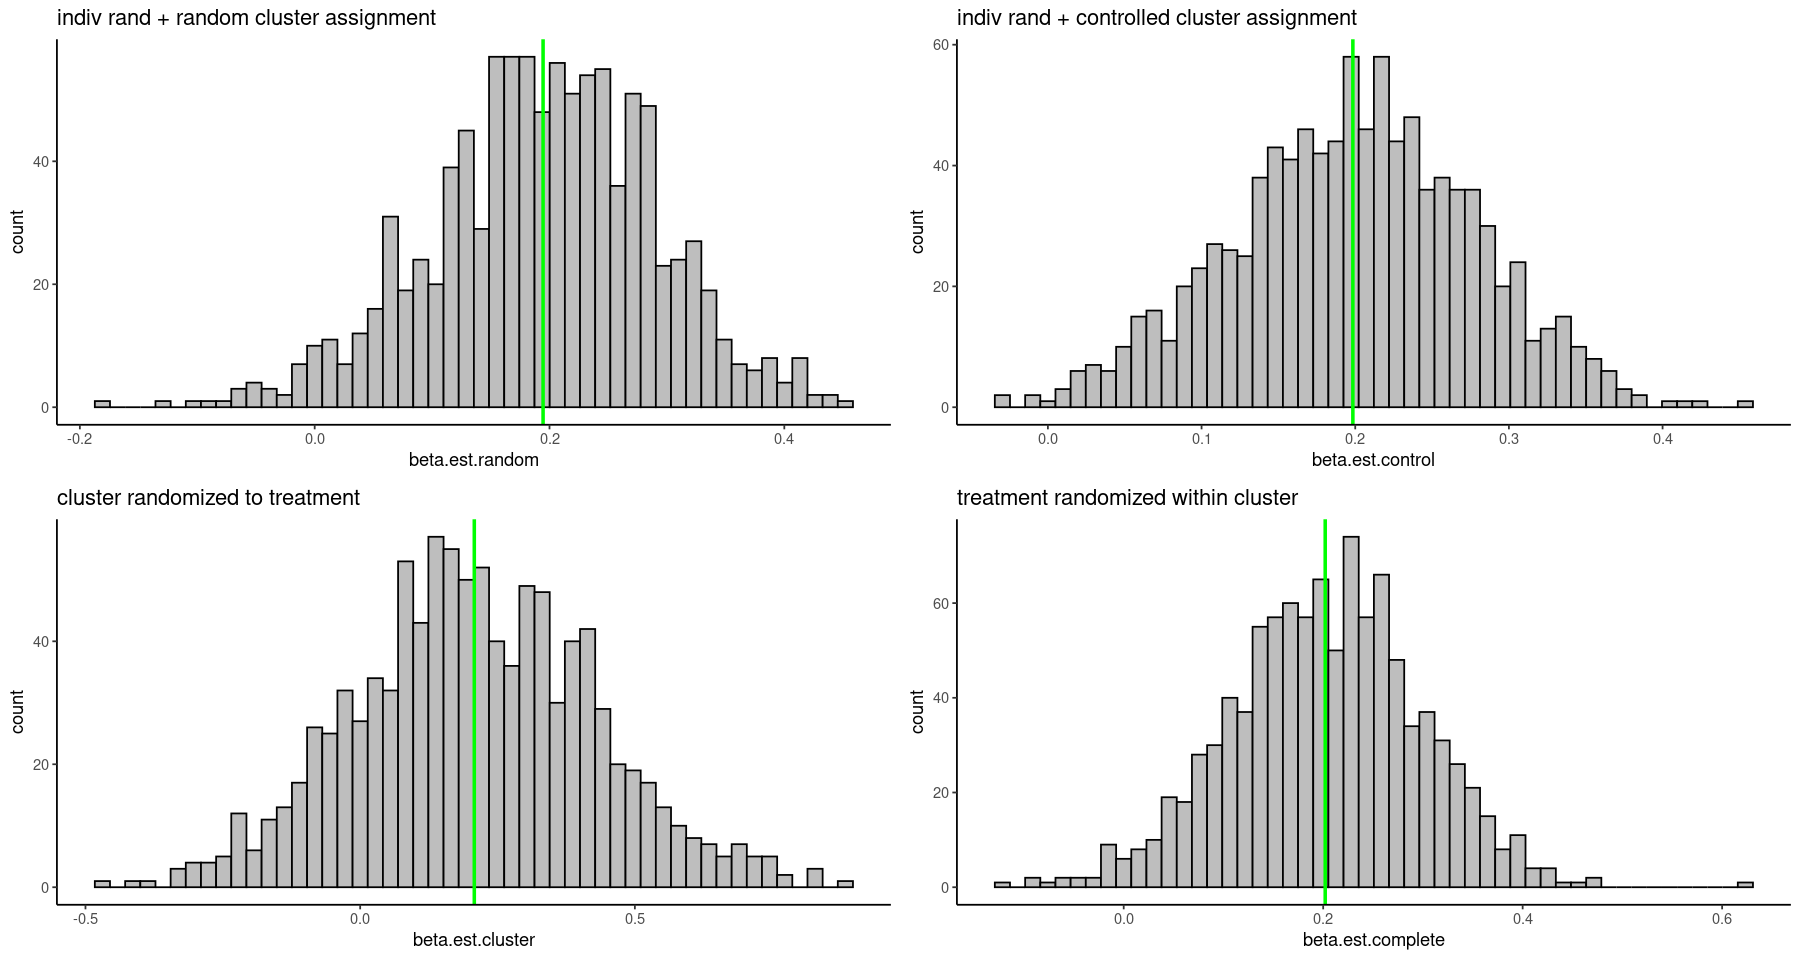

In [43]:
options(repr.plot.width = 15, repr.plot.height =8) 

hist.random=ggplot(beta.est.df, aes(x=beta.est.random)) + 
  geom_histogram(bins=50,color='black',fill='grey' )+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+
ggtitle( 'indiv rand + random cluster assignment'  )+
geom_vline(xintercept=mean(beta.est.df$beta.est.random), color = "green", linewidth=1)

hist.control=ggplot(beta.est.df, aes(x=beta.est.control)) + 
  geom_histogram(bins=50,color='black',fill='grey' )+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+
ggtitle( 'indiv rand + controlled cluster assignment' )+
geom_vline(xintercept=mean(beta.est.df$beta.est.control), color = "green", linewidth=1)

hist.cluster=ggplot(beta.est.df, aes(x=beta.est.cluster)) + 
  geom_histogram(bins=50,color='black',fill='grey' )+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+
ggtitle( 'cluster randomized to treatment' )+
geom_vline(xintercept=mean(beta.est.df$beta.est.cluster, na.rm=TRUE), color = "green", linewidth=1)


hist.complete=ggplot(beta.est.df, aes(x=beta.est.complete)) + 
  geom_histogram(bins=50,color='black',fill='grey' )+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+
ggtitle( 'treatment randomized within cluster' )+
geom_vline(xintercept=mean(beta.est.df$beta.est.complete), color = "green", linewidth=1)

grid.arrange(hist.random,hist.control,hist.cluster,hist.complete,ncol=2)


In [44]:
pwr.est.random=sim.df.random[,2]

pwr.est.control=sim.df.control[,2]

pwr.est.cluster=sim.df.cluster[,2]

pwr.est.complete=sim.df.complete[,2]

pwr.est.df=data.frame(pwr.est.random,pwr.est.control, pwr.est.cluster, pwr.est.complete)
head(pwr.est.df)

,pwr.est.random,pwr.est.control,pwr.est.cluster,pwr.est.complete
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.5,0.52,0.54,0.54
2,0.5,0.52,0.54,0.54
3,0.5,0.52,0.54,0.54
4,0.5,0.52,0.54,0.54
5,0.5,0.52,0.54,0.54
6,0.5,0.52,0.54,0.54


We now see that the estimates from cluster randomization is highly variable. And that is expected since icc between observations is very high which translates to high variance between clusters.

The other approaches remain similar in their variability. 

And as expected, all $\beta$ estimates are unbiased. 

$\textbf{1. Randomize to treatment then assign to doctors in a random fashion.}$

In [63]:
# Generate data following the stragey above. It reflects the settings in UTI data from Min. 

options(scipen=999)
beta=0.2 # treatment effect. 
sigma_e=1
# calculate the required sample size for cluster randomization. Suppose that we have a fixed number of clusters and that there are equal number of subjects within each cluster. 
n.group1=cont.sample.size(m1=9.0,
                 m2=9.0+beta,
                 sd=sigma_e,
                 type_I_error=0.05, 
                 type_II_error=0.2)


k=10 # 10, 20, 50, 100 , the number of equal sized clusters
ni=500 # a fixed number of subjects per treatment group
N=ni*2 # total number of patients in the trial. 

# calculate the variance for cluster random effect. 
icc=0.5   #k/(n.group1) # maximum allowable icc for the current number of clusters is  k/n.group1

sigma_b=icc*sigma_e/(1-icc)


# Randomize patients to treatment 
trt=rbinom(n=N,size=1, prob=0.5)

## If assigning doctors to patients in a random fashion without conditioning on treatment assigned to
cluster.assigment=sample(1:k, size=N, replace=TRUE)

# # x-beta 
xb=beta*trt # make sure to use the treatment variable that acts behind the scene!

# # simulate cluster random intercept (for now)  
clust.eff=rnorm(n=k, mean=0, sigma_b) # number of clusters is k

clust.eff.vec=clust.eff[cluster.assigment] # assign each cluster to its random intercept 

# # generate outcome variable yijk using equation in model 1. 
y=rnorm(N, mean=xb,  sigma_e)+clust.eff.vec

# # combine into a dataframe 

clust.df=data.frame(y=y, trt=trt,cluster.assigned=cluster.assigment, 
                    cluster_random_interc=clust.eff.vec) # add icc, number of clusters at a later date. 


head(clust.df)

# sanity checks 
table( cluster.assigment, trt)

,y,trt,cluster.assigned,cluster_random_interc
,<dbl>,<int>,<int>,<dbl>
1,0.9569542,1,5,-0.1923395
2,1.6210919,1,4,0.9819804
3,0.1230638,1,2,0.7359871
4,1.9102954,0,3,1.5442268
5,-2.8938740,0,1,-1.3838635
6,-1.4921075,0,9,-1.5457266


                 trt
cluster.assigment  0  1
               1  50 44
               2  41 61
               3  49 31
               4  53 46
               5  55 51
               6  42 56
               7  49 48
               8  52 37
               9  63 63
               10 53 56

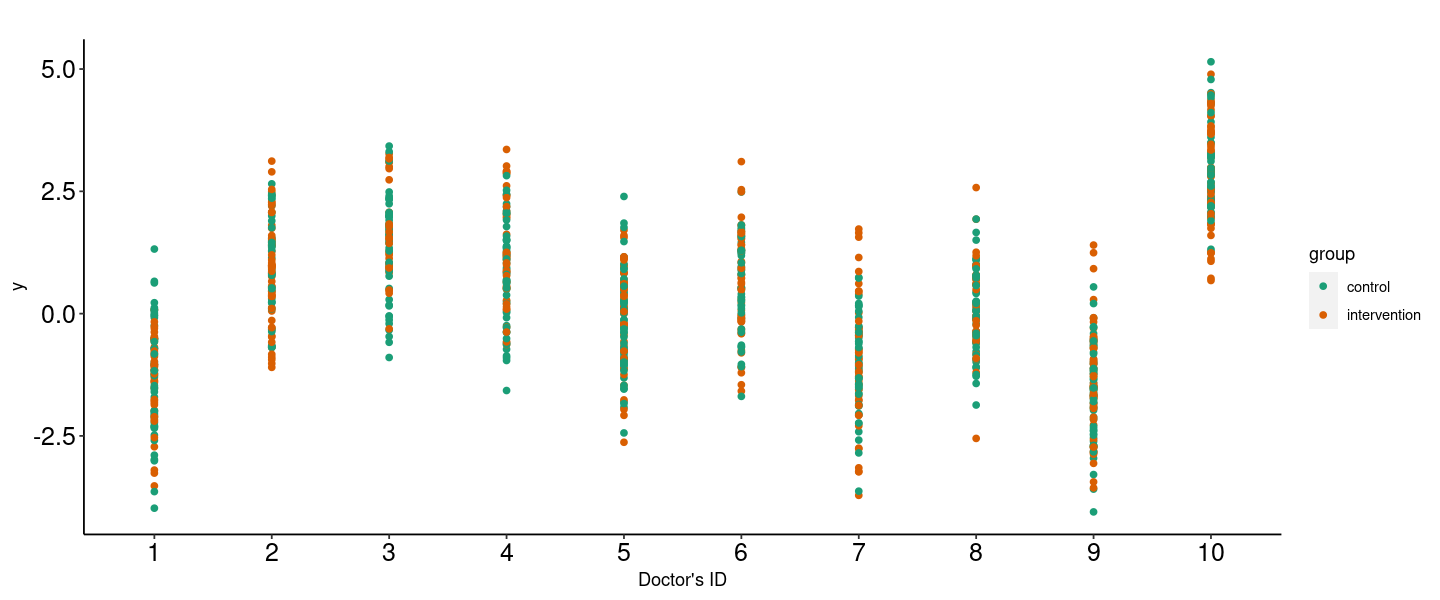

In [64]:
clust.df$cluster.assigned=as.factor(clust.df$cluster.assigned)
clust.df$group=ifelse(clust.df$trt==1, 'intervention', 'control')

                       
options(repr.plot.width = 12, repr.plot.height =5) 

plot.overall=ggplot(clust.df, aes(x=cluster.assigned, y=y, group=group)  )+
geom_point(aes(color=group))+scale_color_brewer(palette="Dark2")+
ylim( min(clust.df$y), max(clust.df$y))+
labs(x="Doctor's ID",y="y")+
theme(axis.text.x = element_text(#face = "bold", 
                            color ="black", 
                           size = 15, angle = 0), 
     axis.text.y = element_text(color ="black", 
                           size = 15,))+
ggtitle( '' )+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

plot.overall

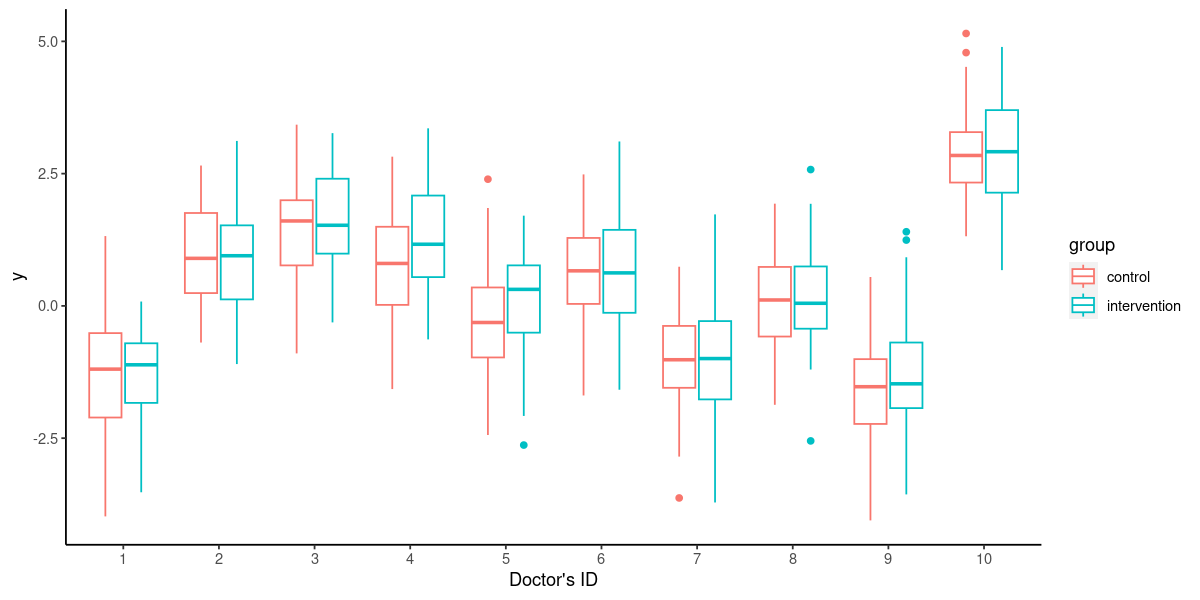

In [69]:
options(repr.plot.width = 10, repr.plot.height =5) 
box.random=ggplot(clust.df, aes(x=cluster.assigned, y=y, color=group)) + 
labs(x="Doctor's ID",y="y")+
  geom_boxplot()+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

box.random

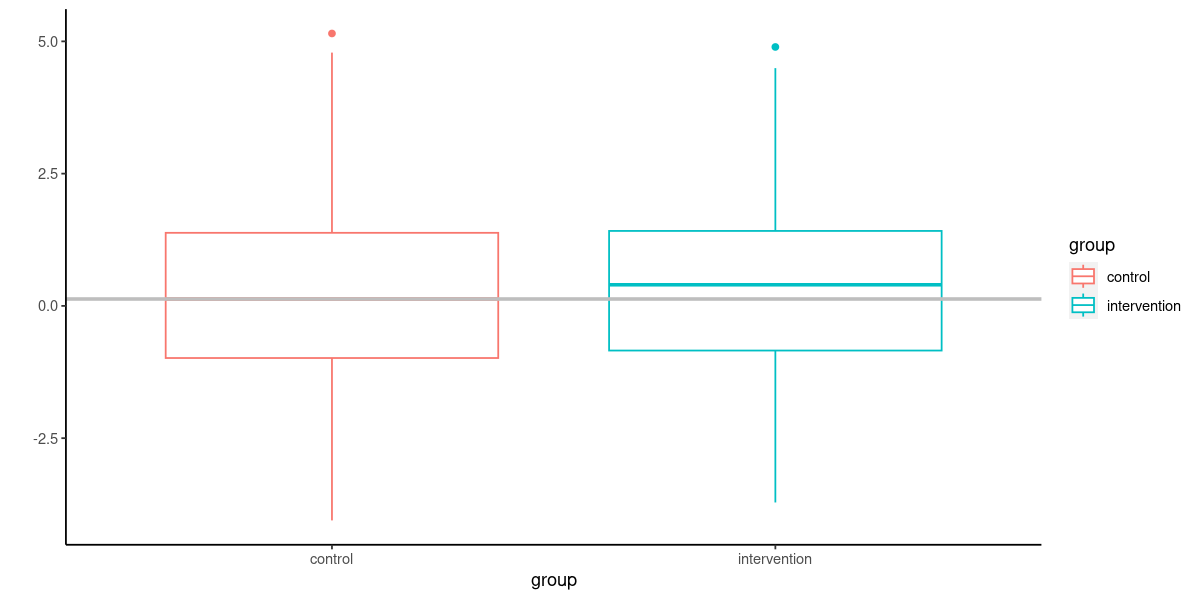

In [78]:
# check if intervention is different from control if we ignore cluster variable. 
options(repr.plot.width = 10, repr.plot.height =5) 
box.overall=ggplot(clust.df, aes(x=group, y=y, color=group)) + 
  geom_boxplot()+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+
ylab('')+
geom_hline(yintercept=median(clust.df$y[clust.df$trt==0] ), color = "grey", linewidth=1)

box.overall


box.cluster.overall= arrangeGrob(box.random,box.overall, nrow = 1) #generates g
ggsave(file=paste0(tab_fig_path,"sources_of_variability_cluster.svg"), 
       plot=box.cluster.overall, width=18, height=5 )


In [19]:
# # plot outcome by doctor for each treatment group. 

# clust.df.interv=clust.df[clust.df$trt==1, ]                         
# options(repr.plot.width = 12, repr.plot.height =10) 

# plot.interv=ggplot(clust.df.interv, aes(x=cluster.assigned, y=y, group=group)  )+
# geom_point(color='chocolate')+scale_color_brewer(palette="Dark2")+
# ylim( min(clust.df$y), max(clust.df$y))+
# labs(x=" ",y="outcome")+
# theme(axis.text.x = element_text(#face = "bold", 
#                             color ="black", 
#                            size = 15, angle = 0), 
#      axis.text.y = element_text(color ="black", 
#                            size = 15,))+
# ggtitle( 'intervention group' )+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
# panel.background = element_blank(), axis.line = element_line(colour = "black"))



# # Control group 

# clust.df.control=clust.df[clust.df$trt==0, ]                        

# plot.control=ggplot(clust.df.control, aes(x=cluster.assigned, y=y, group=group)  )+
# geom_point(color='blue' )+scale_color_brewer(palette="Dark2")+
# ylim( min(clust.df$y), max(clust.df$y))+
# labs(x="Doctor's ID",y="outcome")+
# theme(axis.text.x = element_text(#face = "bold", 
#                             color ="black", 
#                            size = 15, angle = 0), 
#      axis.text.y = element_text(color ="black", 
#                            size = 15,))+
# ggtitle( 'control group' )+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
# panel.background = element_blank(), axis.line = element_line(colour = "black"))


# grid.arrange(plot.interv,plot.control, ncol=1)


$\textbf{Findings}$

We see that there is little to no variation in outcome between intervention and control group for a 
specific doctor. That means outcome between intervention and control are highly correlated for the same doctor. 

It is likely that cluster assignment after treatment randomization does not affect the **estimation of the treatment effect value**. Instead, it appears that it only affects whether we decide it is significant or not through its **effect on the variance**. So, the estimand is not affected, the statistical test of the estimand is the one that is affected. 

Now, if this is true, then where is the 'contamination' problem coming from as Min argues? 

If we are to rely heavily on the actual definition of contamination, then Min's model does not apply.


$\textbf{2. Randomize to treatment then assign to doctors in a controlled fashion}$

That is, randomize such that each doctor gets equal number of intervetion and control patients.

In [20]:
# Randomize to treatment but assign to clusters in a controlled manner as described above

options(scipen=999)
beta=0.4 # treatment effect. 
sigma_e=1
# calculate the required sample size for cluster randomization. Suppose that we have a fixed number of clusters and that there are equal number of subjects within each cluster. 
n.group1=cont.sample.size(m1=9.0,
                 m2=9.0+beta,
                 sd=sigma_e,
                 type_I_error=0.05, 
                 type_II_error=0.2)


k=10 # 10, 20, 50, 100 , the number of equal sized clusters
ni=500 # a fixed number of subjects per treatment group
N=ni*2 # total number of patients in the trial. 

# calculate the variance for cluster random effect. 
icc=0.5   #k/(n.group1) # maximum allowable icc for the current number of clusters is  k/n.group1

sigma_b=icc*sigma_e/(1-icc)


# Randomize patients to treatment 
trt=rbinom(n=N,size=1, prob=0.5)

trt=sort(trt) # sort 

## Assign to clusters in a controlled fashion. 
cluster.assigment=c( rep(1:k, each=ni/k ), rep(1:k, each=ni/k ))

# # x-beta 
xb=beta*trt # make sure to use the treatment variable that acts behind the scene!

# # simulate cluster random intercept (for now)  
clust.eff=rnorm(n=k, mean=0, sigma_b) # number of clusters is k

clust.eff.vec=clust.eff[cluster.assigment] # assign each cluster to its random intercept 

# # generate outcome variable yijk using equation in model 1. 
y=rnorm(N, mean=xb,  sigma_e)+clust.eff.vec

# # combine into a dataframe 

clust.df=data.frame(y=y, trt=trt,cluster.assigned=cluster.assigment, 
                    cluster_random_interc=clust.eff.vec) # add icc, number of clusters at a later date. 

head(clust.df)

# sanity checks
table(cluster.assigment, trt)

,y,trt,cluster.assigned,cluster_random_interc
,<dbl>,<int>,<int>,<dbl>
1,1.6703688,0,1,1.134879
2,1.7444219,0,1,1.134879
3,-0.9757606,0,1,1.134879
4,2.4115903,0,1,1.134879
5,1.8521685,0,1,1.134879
6,2.2149179,0,1,1.134879


                 trt
cluster.assigment  0  1
               1  50 50
               2  50 50
               3  50 50
               4  50 50
               5  50 50
               6  50 50
               7  50 50
               8  50 50
               9  50 50
               10 50 50

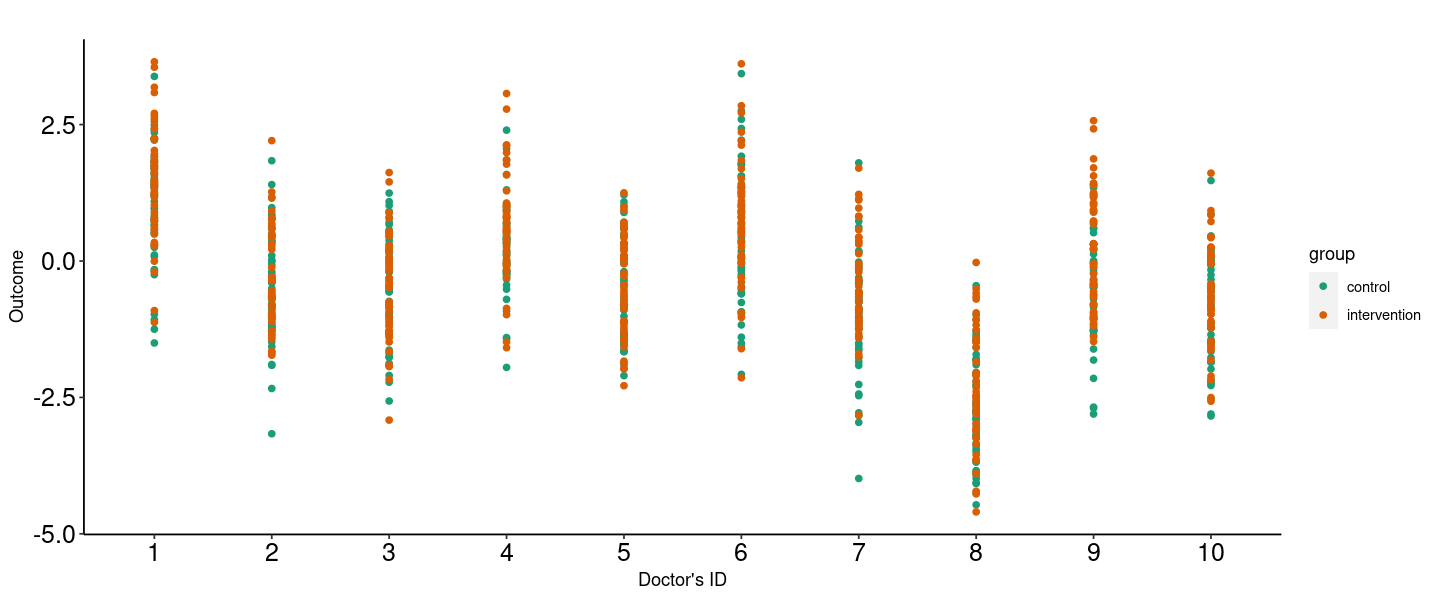

In [21]:
clust.df$cluster.assigned=as.factor(clust.df$cluster.assigned)
clust.df$group=ifelse(clust.df$trt==1, 'intervention', 'control')
                      
options(repr.plot.width = 12, repr.plot.height =5) 

plot.overall=ggplot(clust.df, aes(x=cluster.assigned, y=y, group=group)  )+
geom_point(aes(color=group))+scale_color_brewer(palette="Dark2")+
ylim( min(clust.df$y), max(clust.df$y))+
labs(x="Doctor's ID",y="Outcome")+
theme(axis.text.x = element_text(#face = "bold", 
                            color ="black", 
                           size = 15, angle = 0), 
     axis.text.y = element_text(color ="black", 
                           size = 15,))+
ggtitle( '' )+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

plot.overall

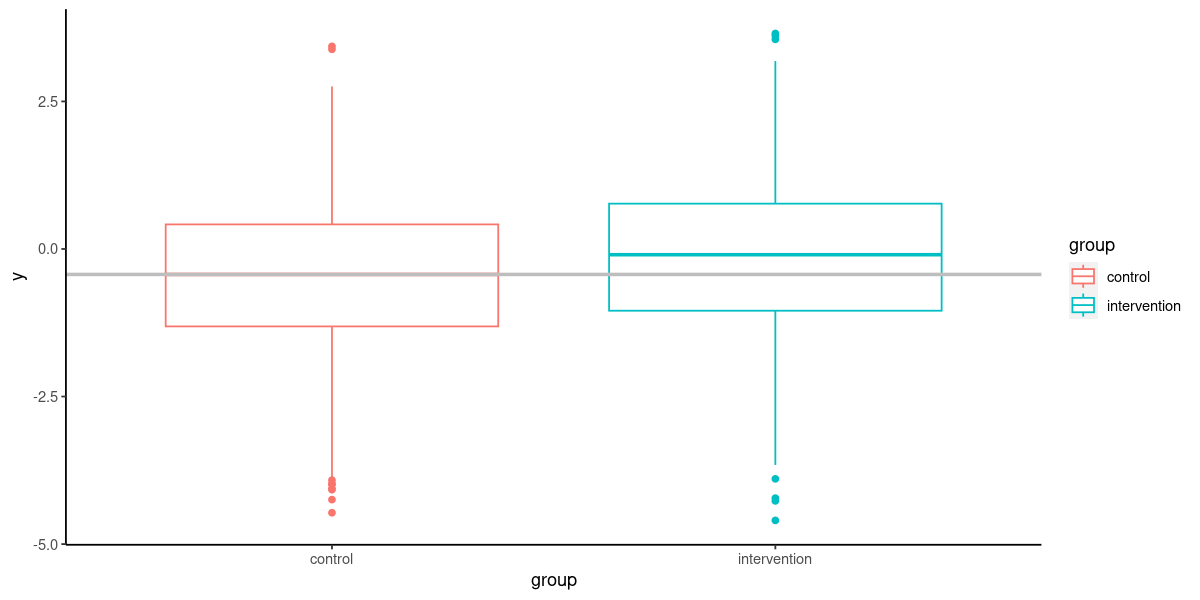

In [22]:
# check if intervention is different from control if we ignore cluster variable. 
options(repr.plot.width = 10, repr.plot.height =5) 
box.p=ggplot(clust.df, aes(x=group, y=y, color=group)) + 
  geom_boxplot()+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+
geom_hline(yintercept=median(clust.df$y[clust.df$trt==0] ), color = "grey", linewidth=1)

box.p

$\textbf{Findings}$

Again, the estimated treatment effect is not affected under this 'factorial  design' way of assigning patients to clusters. It only affects its variance. 

It is also clear that there is doctor's effect that can be captured via a random intercept. But there is no interaction between a doctor and the treatment variable. So, there is no need for the random slope. Of course this is expected because of the structure of the data-generating model. 

$\textbf{3. Randomize clusters to treatments}$

In [69]:
# Conduct cluster randomization and generate the correspond data according to model 1
beta=0.2 # treatment effect. 
sigma_e=1
# calculate the required sample size for cluster randomization. Suppose that we have a fixed number of clusters and that there are equal number of subjects within each cluster. 
n.group1=cont.sample.size(m1=9.0,
                 m2=9.0+beta,
                 sd=sigma_e,
                 type_I_error=0.05, 
                 type_II_error=0.2)

k=10 # 10, 20, 50, 100 , the number of equal sized clusters
ni=500 # a fixed number of subjects per treatment group
N=ni*2 # total number of patients in the trial. 

# calculate the variance for cluster random effect. 
icc=0.9   #k/(n.group1) # maximum allowable icc for the current number of clusters is  k/n.group1
sigma_b=icc*sigma_e/(1-icc)

N=ni*2

# Generate cluster id 
cluster_id=sample(x=1:k,size=N, replace=TRUE)

# Randomize treatment to the k clusters. 
trt.cluster=rbinom(n=k,size=1, prob=0.5) 

trt=trt.cluster[cluster_id] # assign each cluster to its appropriate treatment. 

xb=beta*trt

# simulate cluster random intercept (for now)  
clust.eff=rnorm(n=k, mean=0, sigma_b) # number of clusters is k

clust.vec=clust.eff[cluster_id] # assign each cluster to its random intercept 


# generate outcome variable yijk using equation in model 1. 
y=rnorm(N, mean=xb,  sigma_e)+clust.vec

# combine into a dataframe 

clust.df=data.frame(y=y, trt=trt, cluster.assigned=cluster_id, cluster_random_interc=clust.vec) # add icc, number of clusters at a later date. 

# sanity checks. 
table(cluster_id, trt) # make sure that no cluster has both intervention and control. 
table(cluster_id)
trt.cluster

          trt
cluster_id   0   1
        1   88   0
        2    0 115
        3   91   0
        4    0  92
        5  107   0
        6   98   0
        7    0 113
        8    0  99
        9  103   0
        10  94   0

cluster_id
  1   2   3   4   5   6   7   8   9  10 
 88 115  91  92 107  98 113  99 103  94 

[1] 0 1 0 1 0 0 1 1 0 0

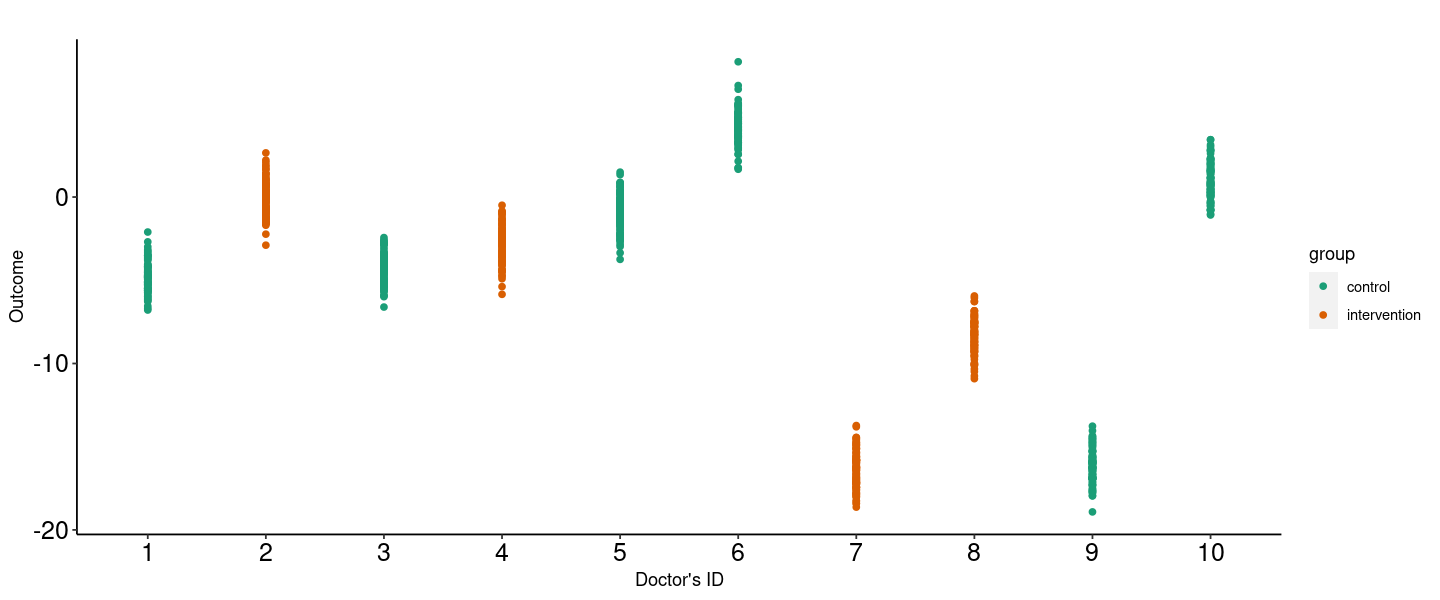

In [70]:
clust.df$cluster.assigned=as.factor(clust.df$cluster.assigned)
clust.df$group=ifelse(clust.df$trt==1, 'intervention', 'control')
                      
options(repr.plot.width = 12, repr.plot.height =5) 

plot.overall=ggplot(clust.df, aes(x=cluster.assigned, y=y, group=group)  )+
geom_point(aes(color=group))+scale_color_brewer(palette="Dark2")+
ylim( min(clust.df$y), max(clust.df$y))+
labs(x="Doctor's ID",y="Outcome")+
theme(axis.text.x = element_text(#face = "bold", 
                            color ="black", 
                           size = 15, angle = 0), 
     axis.text.y = element_text(color ="black", 
                           size = 15,))+
ggtitle( '' )+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

plot.overall

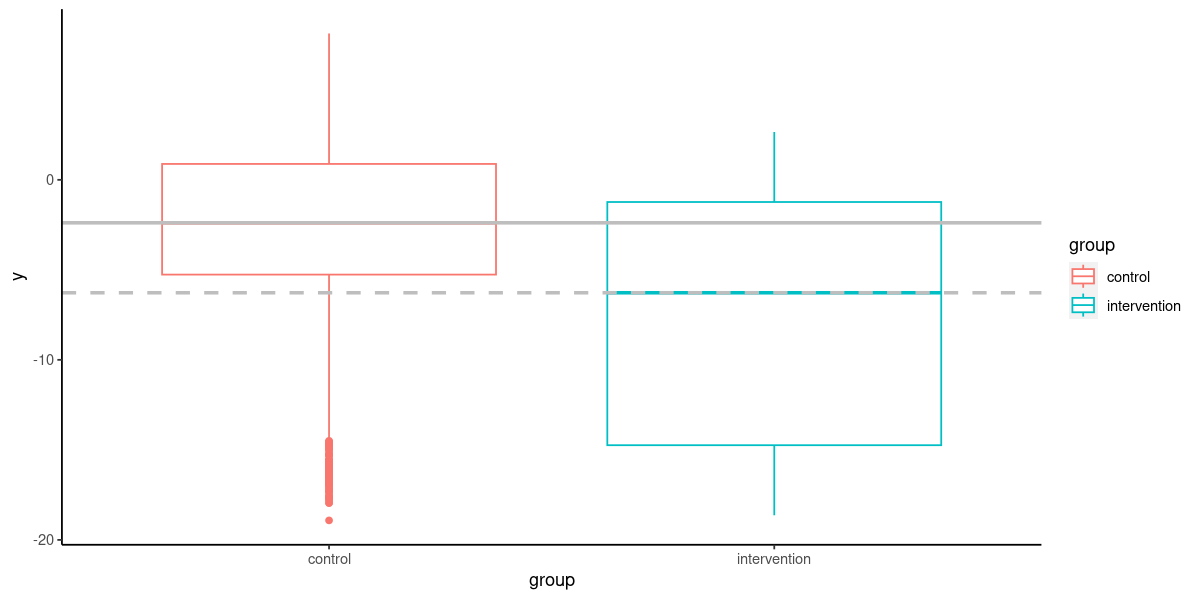

In [71]:
# check if intervention is different from control if we ignore cluster variable. 
options(repr.plot.width = 10, repr.plot.height =5) 
box.p=ggplot(clust.df, aes(x=group, y=y, color=group)) + 
  geom_boxplot()+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+
geom_hline(yintercept=median(clust.df$y[clust.df$trt==0] ), color = "grey", linewidth=1)+
geom_hline(yintercept=median(clust.df$y[clust.df$trt==1] ), linetype='dashed',
           color = "grey", linewidth=1)

box.p

$\textbf{Finding}$

For the above scenario, we expect that the estimate of the treatment effect will be affected by the number of clusters. If the number of clusters is small, then it will be difficult to estimate the treatment effect. Let alone trying to estimate its variance. 

We also expect that if the observations are highly correlated and we have a small number of clusters, we will have difficulties estimating the treatment effect. In addition, we will have a significant reduction in power as icc increases ( demonstrated in previous discussions). 


$\color{red}{ \text{ToDo:}}$ Repeate the scenarios above for nsim=1000 and check if the treatment effect is affected by how 
correlated the observations are.

$\textbf{4. Randomize treatment within a cluster}$

This is called complete block design. That is, the patients are assigned to clusters and then randomized to either intervention or control. This randomization happens within each cluster. 

In [33]:
# Randomize to treatment but assign to clusters in a controlled manner as described above

options(scipen=999)
beta=0.2 # treatment effect. 
sigma_e=1
# calculate the required sample size for cluster randomization. Suppose that we have a fixed number of clusters and that there are equal number of subjects within each cluster. 
n.group1=cont.sample.size(m1=9.0,
                 m2=9.0+beta,
                 sd=sigma_e,
                 type_I_error=0.05, 
                 type_II_error=0.2)


k=10 # 10, 20, 50, 100 , the number of equal sized clusters
ni=400 # a fixed number of subjects per treatment group
N=ni*2 # total number of patients in the trial. 

# calculate the variance for cluster random effect. 
icc=0.5   #k/(n.group1) # maximum allowable icc for the current number of clusters is  k/n.group1

sigma_b=icc*sigma_e/(1-icc)


## Assign to clusters in a controlled fashion. 
cluster.assigment=sample(1:k, size=N, replace=TRUE)

# Randomize patients to treatment within each cluster 
trt=NULL
cluster.count=as.vector(table(cluster.assigment)) # count 

for(i in 1:k){
trt[cluster.assigment==i]= rbinom(n=cluster.count[i], size=1, prob=0.5)}


# # x-beta 
xb=beta*trt # make sure to use the treatment variable that acts behind the scene!

# # simulate cluster random intercept (for now)  
clust.eff=rnorm(n=k, mean=0, sigma_b) # number of clusters is k

clust.eff.vec=clust.eff[cluster.assigment] # assign each cluster to its random intercept 

# # generate outcome variable yijk using equation in model 1. 
y=rnorm(N, mean=xb,  sigma_e)+clust.eff.vec

# # combine into a dataframe 

clust.df=data.frame(y=y, trt=trt,cluster.assigned=cluster.assigment, 
                    cluster_random_interc=clust.eff.vec) # add icc, number of clusters at a later date. 

head(clust.df)

# sanity checks
table(cluster.assigment, trt)

,y,trt,cluster.assigned,cluster_random_interc
,<dbl>,<int>,<int>,<dbl>
1,-1.304429,0,6,0.6801406
2,-0.496273,0,10,-0.6237765
3,1.196342,0,6,0.6801406
4,-1.445568,1,10,-0.6237765
5,-1.363310,1,9,-0.5396045
6,1.504358,0,6,0.6801406


                 trt
cluster.assigment  0  1
               1  27 44
               2  35 37
               3  31 47
               4  43 47
               5  41 33
               6  37 55
               7  40 41
               8  38 38
               9  50 38
               10 43 35

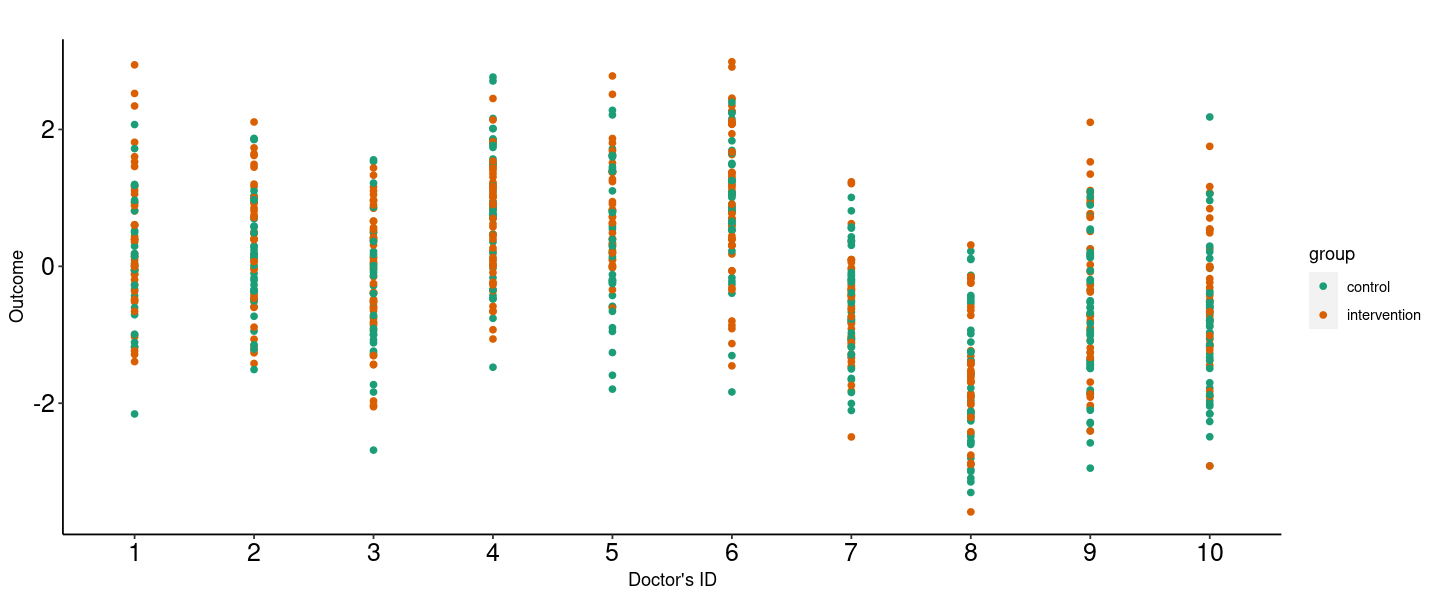

In [34]:
clust.df$cluster.assigned=as.factor(clust.df$cluster.assigned)
clust.df$group=ifelse(clust.df$trt==1, 'intervention', 'control')
                      
options(repr.plot.width = 12, repr.plot.height =5) 

plot.overall=ggplot(clust.df, aes(x=cluster.assigned, y=y, group=group)  )+
geom_point(aes(color=group))+scale_color_brewer(palette="Dark2")+
ylim( min(clust.df$y), max(clust.df$y))+
labs(x="Doctor's ID",y="Outcome")+
theme(axis.text.x = element_text(#face = "bold", 
                            color ="black", 
                           size = 15, angle = 0), 
     axis.text.y = element_text(color ="black", 
                           size = 15,))+
ggtitle( '' )+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

plot.overall

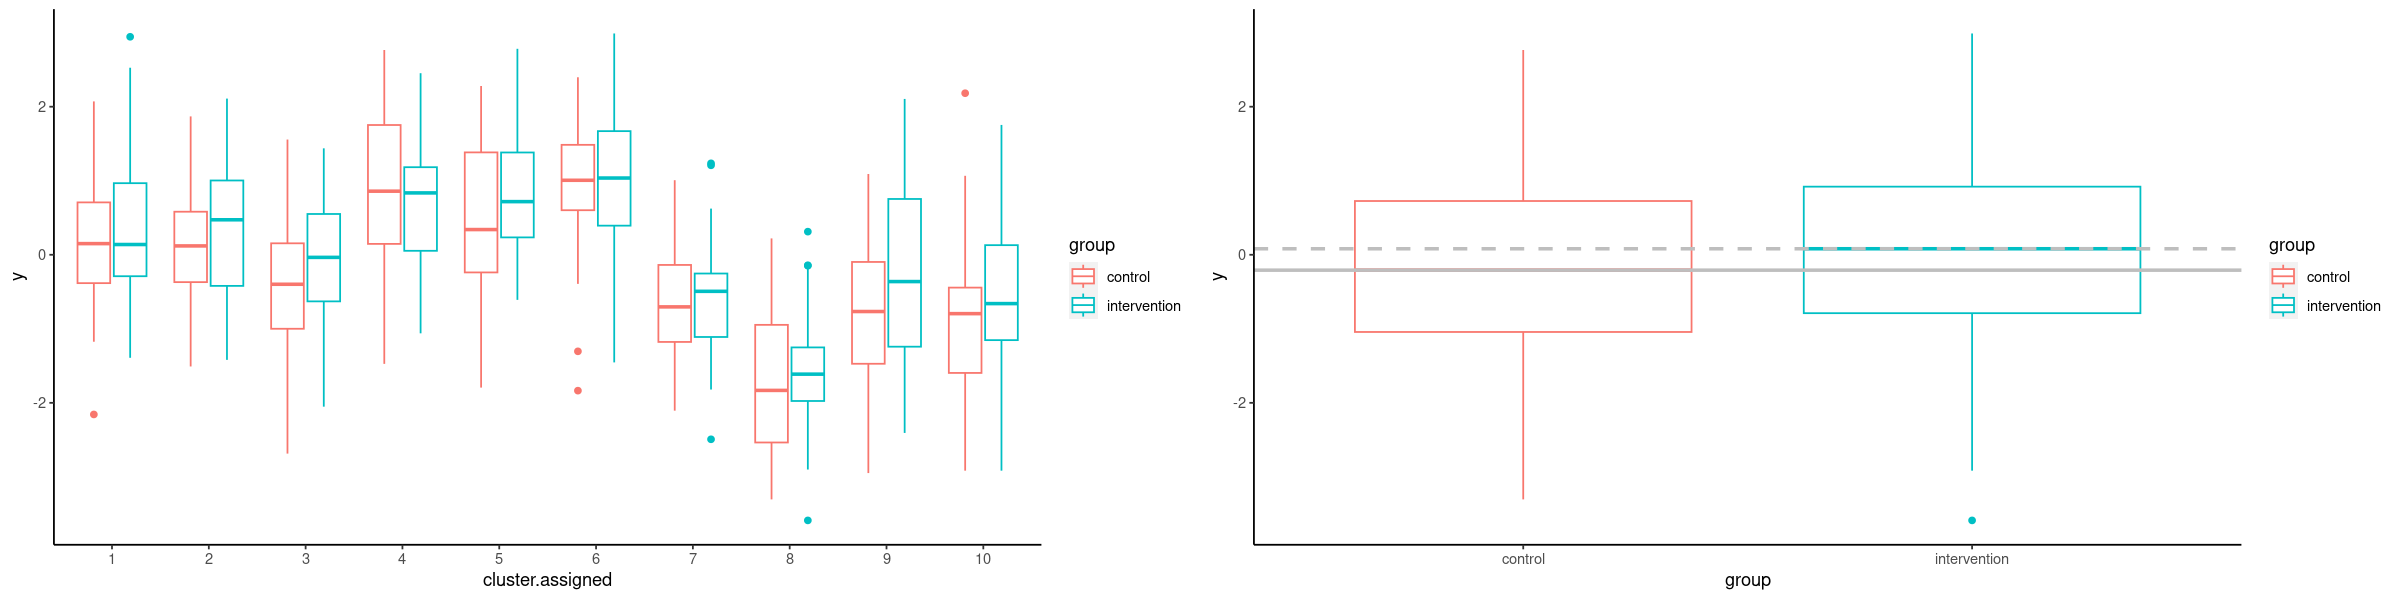

In [35]:
# check if intervention is different from control if we ignore cluster variable. 
options(repr.plot.width = 20, repr.plot.height =5) 
box.p=ggplot(clust.df, aes(x=cluster.assigned, y=y, color=group)) + 
  geom_boxplot()+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

# check if intervention is different from control if we ignore cluster variable. 
box.p2=ggplot(clust.df, aes(x=group, y=y, color=group)) + 
  geom_boxplot()+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+
geom_hline(yintercept=median(clust.df$y[clust.df$trt==0] ), color = "grey", linewidth=1)+
geom_hline(yintercept=median(clust.df$y[clust.df$trt==1] ), linetype='dashed',
           color = "grey", linewidth=1)

grid.arrange(box.p,box.p2,ncol=2)

$\textbf{5. Randomize to treatment and then to clusters. Include cluster/treatment interaction as a random slope}$

In [12]:
# Randomize to treatment but assign to clusters in a controlled manner as described above

options(scipen=999)
beta=0.2 # treatment effect. 
sigma_e=1
# calculate the required sample size for cluster randomization. Suppose that we have a fixed number of clusters and that there are equal number of subjects within each cluster. 
n.group1=cont.sample.size(m1=9.0,
                 m2=9.0+beta,
                 sd=sigma_e,
                 type_I_error=0.05, 
                 type_II_error=0.2)


k=10 # 10, 20, 50, 100 , the number of equal sized clusters
ni=500 # a fixed number of subjects per treatment group
N=ni*2 # total number of patients in the trial. 

# calculate the variance for cluster random effect. 
icc=0.5   #k/(n.group1) # maximum allowable icc for the current number of clusters is  k/n.group1

sigma_b=icc*sigma_e/(1-icc)


# Randomize patients to treatment 
trt=rbinom(n=N,size=1, prob=0.5)

trt=sort(trt) # sort (we sort it because of the way clusters are assigned.)

## Assign to clusters in a controlled fashion. 
cluster.assigment=c( rep(1:k, each=ni/k ), rep(1:k, each=ni/k ))

# # x-beta 
xb=beta*trt # make sure to use the treatment variable that acts behind the scene!

# # simulate cluster random intercept + random slope. 
varcov.mat=matrix(c(sigma_b, 0.01, 0.01, sigma_b/0.9), 2,2) # 
varcov.mat
clust.eff=mvrnorm(n = k, rep(0, 2), varcov.mat) #rnorm(n=k, mean=0, sigma_b) # number of clusters is k

clust.eff.mat=clust.eff[cluster.assigment, ] # assign each cluster to its random intercept 

# # # generate outcome variable yijk using equation in model 1. 
y=rnorm(N, mean=xb,  sigma_e)+clust.eff.mat[,1]+clust.eff.mat[,2]*trt

# # combine into a dataframe 
cluster_random_eff=clust.eff.mat
colnames(cluster_random_eff)=c('randm interc', 'randm slope')
clust.df=data.frame(y=y, trt=trt,cluster.assigned=cluster.assigment, 
                    cluster_random_eff) # add icc, number of clusters at a later date. 

head(clust.df)
# sanity checks
table(cluster.assigment, trt)


1.00,0.010000
0.01,1.111111


,y,trt,cluster.assigned,randm.interc,randm.slope
,<dbl>,<int>,<int>,<dbl>,<dbl>
1,0.100215345,0,1,0.1832196,-0.5558782
2,0.288048272,0,1,0.1832196,-0.5558782
3,-0.039350599,0,1,0.1832196,-0.5558782
4,0.001140946,0,1,0.1832196,-0.5558782
5,0.121737138,0,1,0.1832196,-0.5558782
6,-0.436143282,0,1,0.1832196,-0.5558782


                 trt
cluster.assigment  0  1
               1  77 23
               2  50 50
               3  50 50
               4  50 50
               5  50 50
               6  50 50
               7  50 50
               8  50 50
               9  50 50
               10 50 50

In [107]:
# check if intervention is different from control if we ignore cluster variable. 
clust.df$cluster.assigned=as.factor(clust.df$cluster.assigned)
clust.df$group=ifelse(clust.df$trt==1, 'intervention', 'control')
                      
options(repr.plot.width = 20, repr.plot.height =5) 
box.p3=ggplot(clust.df, aes(x=cluster.assigned, y=y, color=group)) + 
  geom_boxplot()+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+
labs(x="Doctor's ID",y="y")

# check if intervention is different from control if we ignore cluster variable. 
box.p4=ggplot(clust.df, aes(x=group, y=y, color=group)) + 
  geom_boxplot()+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))+
geom_hline(yintercept=median(clust.df$y[clust.df$trt==0] ), color = "grey", linewidth=1)
# geom_hline(yintercept=median(clust.df$y[clust.df$trt==1] ), linetype='dashed',
#            color = "grey", linewidth=1)


#grid.arrange(box.p,box.p2,ncol=2, top='complete block rct')
#grid.arrange(box.p3,box.p4,ncol=2, top='contaminated rct with random slope/treatment interaction')

box.cluster.treatment.interact= arrangeGrob(box.p3,box.p4,ncol=2) #generates g
ggsave(file=paste0(tab_fig_path,"sources_of_variability_with_interaction.svg"), 
       plot=box.cluster.treatment.interact, width=25, height=8 )

Findings 

We see a clear and consitent treatment difference within each cluster. This signifies cluster-treatment interaction as encoded in the data-generating model. But does it induce a difference in variability within the clusters themselves? 

It also appears as though the behaviour from random slope-treatment interaction produce similar results as in the case of commplete block randomization. The only difference is that in the former, some clusters may indicate that control group is doing better than the intervention group. 

The interaction between cluster-treatment is included in this session for completeness but will not be explored further. Interpretation of the estimated treatment effect becomes an issue of concern. As recommended in the ICH, this should only be explored as a secondary objective. 

**Todo:** Figure out how to calculate icc in the presence of random slope.

$\textbf{Evaluate the impact of clustering scheme on type I error}$

Motivated by the arguments in *''Kahan, B. C., & Morris, T. P. (2013). Assessing potential sources of clustering in individually randomised trials. BMC medical research methodology, 13(1), 1-9.''* paper

If clustering is ignorable, then there is minimal impact on type I error or standard error estimates even if ICC>0. However, even if it is ignorable and the ICC>0, excluding it from the model decreases statistical power. 

Carry out simulation to verify these claims. 

Note that the estimated treatment effect is not the issue, the issue is whether we get correct type I and II errors. 

$\textbf{Evaluate the impact of clustering scheme on power}$

In [92]:
N=400*2
k=400
nsim=500
beta=0.2
exp.pwr=0.8
# see effect on power as icc increases
sigma_e=1
icc.from.tau=function(sigma_b){
    return( round( sigma_b/(sigma_b+sigma_e), 2  ) )
}

sigma_b.vec=matrix( c(0.1, 1, 1.5, 2), nrow=1) # match Min's tau values 

icc.vec=apply(X=sigma_b.vec, MARGIN=2, FUN=icc.from.tau)


icc.vs.pwr.df.random=NULL
for ( ix in 1:length(icc.vec)){
    icc.vs.pwr.df.random[ix]=beta.hats.func(beta=beta, 
            N=N, k=k,
            sigma_e=1,icc=icc.vec[ix],
            nsim=nsim,
          cluster.assign.type='random')[1,2]
}

icc.vs.pwr.df.control=NULL
for ( ix in 1:length(icc.vec)){
    icc.vs.pwr.df.control[ix]=beta.hats.func(beta=beta, 
            N=N, k=k,
            sigma_e=1,icc=icc.vec[ix],
            nsim=nsim,
          cluster.assign.type='control')[1,2]
}


icc.vs.pwr.df.cluster=NULL
for ( ix in 1:length(icc.vec)){
    icc.vs.pwr.df.cluster[ix]=beta.hats.func(beta=beta, 
            N=N, k=k,
            sigma_e=1,icc=icc.vec[ix],
            nsim=nsim,
          cluster.assign.type='cluster')[1,2]
}

icc.vs.pwr.df.complete=NULL
for ( ix in 1:length(icc.vec)){
    icc.vs.pwr.df.complete[ix]=beta.hats.func(beta=beta, 
            N=N, k=k,
            sigma_e=1,icc=icc.vec[ix],
            nsim=nsim,
          cluster.assign.type='complete')[1,2]
}


icc.vs.pwr.df.control.interact=NULL
for ( ix in 1:length(icc.vec)){
    icc.vs.pwr.df.control.interact[ix]=beta.hats.func(beta=beta, 
            N=N, k=k,
            sigma_e=1,icc=icc.vec[ix],
            nsim=nsim,
          cluster.assign.type='control.interact')[1,2]
}

In [93]:
est.pwr.vec=c(icc.vs.pwr.df.random,
                  icc.vs.pwr.df.control, 
                  icc.vs.pwr.df.cluster,
                  icc.vs.pwr.df.complete, 
              icc.vs.pwr.df.control.interact, 
              rep(exp.pwr, length(icc.vs.pwr.df.complete) ))

cluster.scheme=rep( c('random cluster','contaminated RCT', 
                      'cluster RCT', 'complete block RCT', 'contaminated RCT w\ interaction', 'simple RCT'), each=length(icc.vec) )

pwr.vs.icc.df=data.frame(icc=rep(icc.vec, 6), tau=rep(c(0.1, 1, 1.5, 2), 6),
                         est.power=est.pwr.vec, 
                         key=cluster.scheme )
pwr.vs.icc.df

icc,tau,est.power,key
<dbl>,<dbl>,<dbl>,<chr>
0.09,0.1,0.81,random cluster
0.50,1.0,0.49,random cluster
0.60,1.5,0.35,random cluster
0.67,2.0,0.25,random cluster
0.09,0.1,0.78,contaminated RCT
0.50,1.0,0.52,contaminated RCT
0.60,1.5,0.23,contaminated RCT
0.67,2.0,0.07,contaminated RCT
0.09,0.1,0.80,cluster RCT


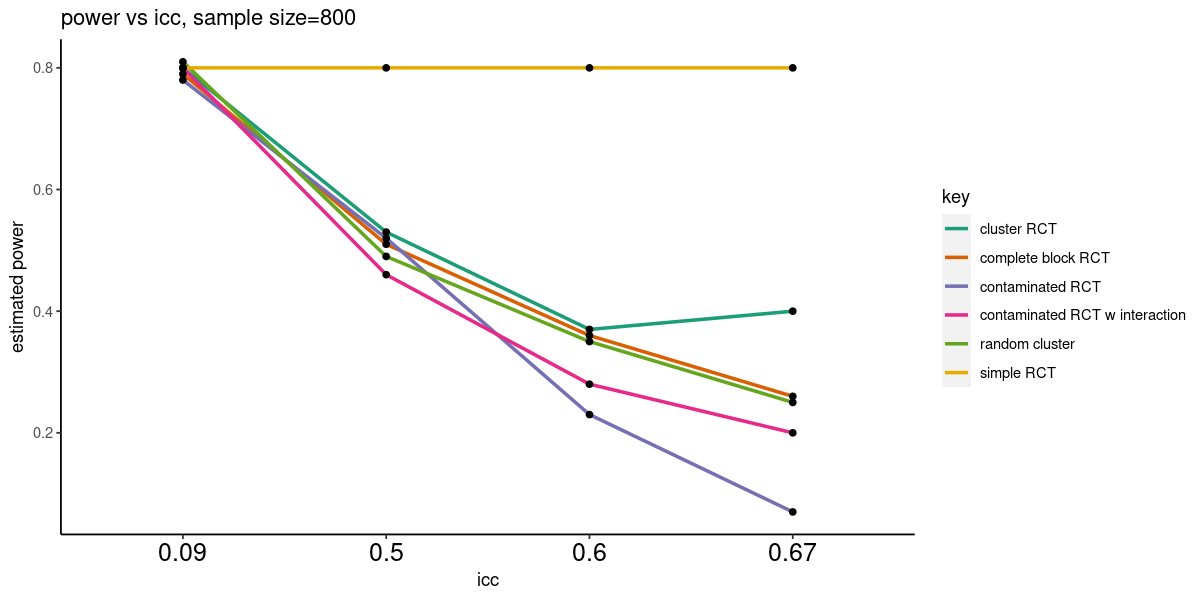

In [94]:
options(repr.plot.width = 10, repr.plot.height =5) 
pwr.vs.icc.df$key=as.factor(pwr.vs.icc.df$key)
plot7=ggplot(pwr.vs.icc.df, aes(x=as.factor(icc), y=est.power, group=key))+
geom_line(aes(
    color=key
), lwd=1.0)+
geom_point()+scale_color_brewer(palette="Dark2")+
#ylim(0,0.2)+
labs(x="icc",y="estimated power")+
theme(axis.text.x = element_text(#face = "bold", 
                            color ="black", 
                           size = 15, angle = 0))+
ggtitle( paste0('power vs icc, sample size=',N))+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

plot7
#ggsave(file=paste0(tab_fig_path,"power_vs_icc_by_samplesize.svg"), plot=plot7, width=15, height=5 )

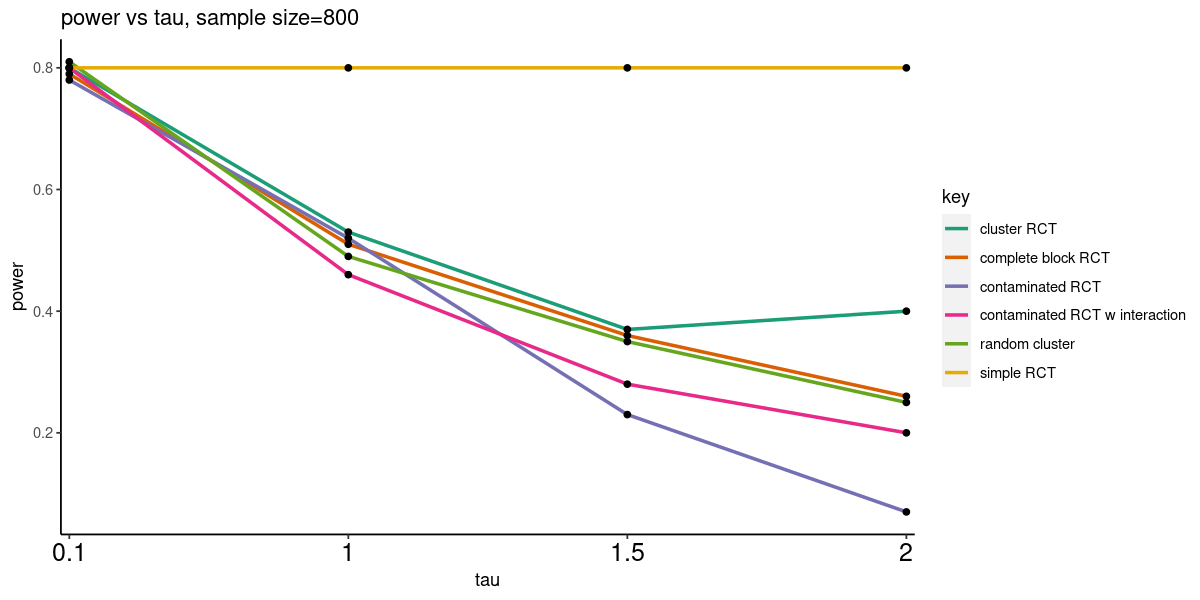

In [95]:
options(repr.plot.width = 10, repr.plot.height =5) 
pwr.vs.icc.df$key=as.factor(pwr.vs.icc.df$key)
plot7=ggplot(pwr.vs.icc.df, aes(x=as.factor(tau), y=est.power, group=key))+
geom_line(aes(
    color=key
), lwd=1.0)+
geom_point()+scale_color_brewer(palette="Dark2")+
scale_x_discrete(limits =factor(c(0.1, 1, 1.5, 2)), expand = c(0.01, 0.0))+
#ylim(0,1)+
labs(x="tau",y="power")+
theme(axis.text.x = element_text(#face = "bold", 
                            color ="black", 
                           size = 15, angle = 0))+
ggtitle( paste0('power vs tau, sample size=',N))+theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))


plot7
#ggsave(file=paste0(tab_fig_path,"power_vs_icc_by_trial_type_",k,"_clusters.svg"), plot=plot7, width=10, height=5 )

Note that the observed results is a function of fixed sample size, number of clusters, icc and exclusion of clusters in the estimation. 
In fact, if we decrease the number of clusters from 100 to 10, the power plot for cluster RCT changes substantially ( small number of clusters increases the instability of treatment estimate). 

In [96]:
#ggsave(file=paste0(tab_fig_path,"power_vs_icc_by_trial_type_",k,"_clusters.svg"), plot=plot7, width=10, height=5 )